In [9]:
!pip install asyncpraw
!pip install praw
!pip install nest_asyncio


In [100]:
import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')

import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [124]:
import asyncpraw
import pandas as pd
import asyncio
import nest_asyncio

nest_asyncio.apply()

async def fetch_posts(subreddit_name):
    reddit = asyncpraw.Reddit(
        client_id='',          # Replace with your actual client_id
        client_secret='',  # Replace with your actual client_secret
        user_agent='MyApp/0.1 by YourRedditUsername'
    )

    posts = []
    subreddit = await reddit.subreddit(subreddit_name)
    async for post in subreddit.hot(limit=10000):
        posts.append([
            post.title, post.score, post.id, post.subreddit, post.url,
            post.num_comments, post.selftext, post.created
        ])

    return pd.DataFrame(posts, columns=[
        'title', 'score', 'id', 'subreddit', 'url', 'num_comments', 'body', 'created'
    ])
loop = asyncio.get_event_loop()
df = loop.run_until_complete(fetch_posts('Facebook'))
df.head()

,title,score,id,subreddit,url,num_comments,body,created
0,Important PSA: If someone on Reddit sends you ...,947,jsx44s,facebook,https://www.reddit.com/r/facebook/comments/jsx...,0,*Please note: the mod team at /r/facebook is i...,1.605197e+09
1,Remember: r/facebook is an unofficial community,77,1046gt3,facebook,https://www.reddit.com/r/facebook/comments/104...,1,r/facebook is not associated with or endorsed ...,1.672944e+09
2,It’s been over two weeks now:( support is abso...,6,1djzc02,facebook,https://i.redd.it/aqnkm1ppmm7d1.jpeg,6,,1.718846e+09
3,Anyone try the hacked link? Checkpoint/block g...,3,1dk3aeo,facebook,https://www.reddit.com/r/facebook/comments/1dk...,6,"So I'm with y'all, locked out since June 9th, ...",1.718859e+09
4,"Asked Facebook Ai for an image of happiness, a...",3,1dk0mc1,facebook,https://i.redd.it/v8vh1sucym7d1.jpeg,3,"Asked Facebook for an AI image of happiness, a...",1.718850e+09


In [125]:
df.to_csv('sample_reddit.csv')

In [127]:
# Preprocess functions
def clean_data(data):
    return ' '.join(re.sub('([^A-Za-z])', ' ', data).split())

def remove_https(item):
    item_1 = re.sub(r"[(+*)]\S*https?:\S*[(+*)]", "", item)
    item_2 = re.sub('http://\S+|https://\S+', " ", item_1)
    item_3 = re.sub(r"[\[\]]", " ", item_2)
    return item_3

def preprocess_text(text):
    text = clean_data(text)
    text = remove_https(text)
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

df['Cleaned_Body'] = df['body'].apply(preprocess_text)
df['Cleaned_Body'] = df['Cleaned_Body'].astype(str)  # Convert to string if needed
df['Cleaned_Body'].fillna('', inplace=True)
df.sample(5)


,title,score,id,subreddit,url,num_comments,body,created,Cleaned_Body
273,We made a free Bio generator for Facebook prof...,0,1dh3kuz,facebook,https://robopost.app/en/free-tools/bio-generat...,1,,1.718529e+09,
761,I want out of a group as a primary admin. But ...,1,1dblto5,facebook,https://i.redd.it/dmw5xsoi9h5d1.jpeg,5,I created a group a very long time ago. It now...,1.717909e+09,created group long time ago two member admins ...
488,"Facebook log in error, connection lost, and wh...",13,1de2wpi,facebook,https://www.reddit.com/gallery/1de2wpi,25,"My account is still out there, im getting noti...",1.718186e+09,account still im getting notification even ema...
64,I was able to access facebook marketplace and ...,1,1djh8n1,facebook,/r/FacebookMarketplace/comments/1djh6tg/i_was_...,1,,1.718798e+09,
558,My account got hacked and I think deleted and ...,1,1de0kfj,facebook,https://www.reddit.com/r/facebook/comments/1de...,1,My account randomly posted a ad for a car and ...,1.718176e+09,account randomly posted ad car unable edit acc...


In [128]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from textblob import TextBlob, Word, Blobber
from textblob.classifiers import NaiveBayesClassifier
from textblob.taggers import NLTKTagger
import yfinance as yf


In [130]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split  # Ensure this import is included
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.neighbors import KNeighborsClassifier

In [132]:
# Sentiment analysis functions
def analyze_sentiment(data):
    analysis = SIA().polarity_scores(data)
    return analysis['compound']

def get_sentiment(text):
    blob = TextBlob(text)
    sentiment_polarity = blob.sentiment.polarity
    sentiment_subjectivity = blob.sentiment.subjectivity
    if sentiment_polarity > 0:
        sentiment_label = "positive"
    elif sentiment_polarity < 0:
        sentiment_label = "negative"
    else:
        sentiment_label = "neutral"
    # Store result in a dictionary
    result = {"polarity": sentiment_polarity,
              "subjectivity": sentiment_subjectivity,
              "sentiment": sentiment_label}
    return result

df['Sentiment_Score'] = df['Cleaned_Body'].apply(lambda x: analyze_sentiment(x))
df['Sentiment_Analysis'] = df['Cleaned_Body'].apply(get_sentiment)

sentiment = pd.json_normalize(df['Sentiment_Analysis'])
df = df.drop(columns='Sentiment_Analysis')
df = pd.concat([df, sentiment], axis=1)
df.sample(3)

,title,score,id,subreddit,url,num_comments,body,created,Cleaned_Body,Sentiment_Score,polarity,subjectivity,sentiment,polarity,subjectivity,sentiment
567,Every time I try to login to my Facebook accou...,11,1ddf01q,facebook,https://i.redd.it/3mc8qdjj9y5d1.png,22,"This happen to me 3 days ago , and I have all ...",1.718115e+09,happen day ago requirement login password plus...,0.0772,0.500000,0.625000,positive,0.500000,0.625000,positive
684,Can someone help me change the order of the it...,4,1dcbd01,facebook,https://www.reddit.com/r/facebook/comments/1dc...,4,"So, on the left menu bar on the Facebook main ...",1.717988e+09,left menu bar facebook main page desktop list ...,0.9524,0.188095,0.393398,positive,0.188095,0.393398,positive
451,Hacked inactive account on facebook. Changed p...,1,1df1pfh,facebook,https://i.redd.it/5jiwrn2lxc6d1.jpeg,2,I’ve noticed that my inactive acc which i have...,1.718292e+09,noticed inactive acc using nearly year likely ...,-0.1027,0.000000,0.600000,neutral,0.000000,0.600000,neutral


In [133]:
facebook_stock = yf.download('META', start='2023-01-01', end='2023-06-30')
facebook_stock.reset_index(inplace=True)
facebook_stock = facebook_stock[['Date', 'Close']]
facebook_stock.columns = ['date', 'close_price']
facebook_stock.loc[:, 'return'] = facebook_stock['close_price'].pct_change()
facebook_stock.loc[:, 'label'] = facebook_stock['return'].apply(lambda x: 'increase' if x > 0 else ('decrease' if x < 0 else 'no_change'))

facebook_stock.head()

[*********************100%%**********************]  1 of 1 completed
<ipython-input-133-2dc7a0af396c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  facebook_stock.loc[:, 'return'] = facebook_stock['close_price'].pct_change()
<ipython-input-133-2dc7a0af396c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  facebook_stock.loc[:, 'label'] = facebook_stock['return'].apply(lambda x: 'increase' if x > 0 else ('decrease' if x < 0 else 'no_change'))


,date,close_price,return,label
0,2023-01-03,124.739998,NaN,no_change
1,2023-01-04,127.370003,0.021084,increase
2,2023-01-05,126.940002,-0.003376,decrease
3,2023-01-06,130.020004,0.024263,increase
4,2023-01-09,129.470001,-0.004230,decrease


In [134]:
print(df.columns)
print(df.dtypes)

Index(['title', 'score', 'id', 'subreddit', 'url', 'num_comments', 'body',
       'created', 'Cleaned_Body', 'Sentiment_Score', 'polarity',
       'subjectivity', 'sentiment', 'polarity', 'subjectivity', 'sentiment'],
      dtype='object')
title               object
score                int64
id                  object
subreddit           object
url                 object
num_comments         int64
body                object
created            float64
Cleaned_Body        object
Sentiment_Score    float64
polarity           float64
subjectivity       float64
sentiment           object
polarity           float64
subjectivity       float64
sentiment           object
dtype: object


In [135]:
print(facebook_stock.columns)
print(facebook_stock.dtypes)

Index(['date', 'close_price', 'return', 'label'], dtype='object')
date           datetime64[ns]
close_price           float64
return                float64
label                  object
dtype: object


In [136]:
facebook_stock['date'] = pd.to_datetime(facebook_stock['date']).dt.date
facebook_stock[['date','label']]

<ipython-input-136-cabb98ff76bd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  facebook_stock['date'] = pd.to_datetime(facebook_stock['date']).dt.date


,date,label
0,2023-01-03,no_change
1,2023-01-04,increase
2,2023-01-05,decrease
3,2023-01-06,increase
4,2023-01-09,decrease
...,...,...
118,2023-06-23,increase
119,2023-06-26,decrease
120,2023-06-27,increase
121,2023-06-28,decrease


In [137]:
df = pd.merge(df, facebook_stock[['date', 'label']], left_index=True, right_index=True, how='left').dropna(subset=['label'])

In [138]:
if 'label' not in df.columns:
    print("Error: 'label' column not found after merge.")
else:
    print("Successfully merged 'label' column into df.")

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['Cleaned_Body'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, multi_class='auto'),
    'SVM': SVC(probability=True, decision_function_shape='ovr'),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

for model_name, model in models.items():
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

        print(f"Model: {model_name}")
        print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
        print(f"Precision: {precision_score(y_test, y_pred, average='weighted')}")
        print(f"Recall: {recall_score(y_test, y_pred, average='weighted')}")
        print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted')}")
        # if y_proba is not None:
        #     print(f"ROC AUC: {roc_auc_score(y_test, y_proba)}")
        print(classification_report(y_test, y_pred))
        print("-" * 50)
    except ValueError as e:
        print(f"Error occurred with {model_name}: {e}")
        print("-" * 50)


Successfully merged 'label' column into df.
Model: Logistic Regression
Accuracy: 0.52
Precision: 0.468
Recall: 0.52
F1 Score: 0.46901960784313723
              precision    recall  f1-score   support

    decrease       0.40      0.20      0.27        10
    increase       0.55      0.79      0.65        14
   no_change       0.00      0.00      0.00         1

    accuracy                           0.52        25
   macro avg       0.32      0.33      0.30        25
weighted avg       0.47      0.52      0.47        25

--------------------------------------------------
Model: SVM
Accuracy: 0.56
Precision: 0.31360000000000005
Recall: 0.56
F1 Score: 0.40205128205128204
              precision    recall  f1-score   support

    decrease       0.00      0.00      0.00        10
    increase       0.56      1.00      0.72        14
   no_change       0.00      0.00      0.00         1

    accuracy                           0.56        25
   macro avg       0.19      0.33      0.24       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

Model: Random Forest
Accuracy: 0.6
Precision: 0.5975757575757575
Recall: 0.6
F1 Score: 0.5275213675213676
              precision    recall  f1-score   support

    decrease       0.67      0.20      0.31        10
    increase       0.59      0.93      0.72        14
   no_change       0.00      0.00      0.00         1

    accuracy                           0.60        25
   macro avg       0.42      0.38      0.34        25
weighted avg       0.60      0.60      0.53        25

--------------------------------------------------
Model: KNN
Accuracy: 0.56
Precision: 0.31360000000000005
Recall: 0.56
F1 Score: 0.40205128205128204
              precision    recall  f1-score   support

    decrease       0.00      0.00      0.00        10
    increase       0.56      1.00      0.72        14
   no_change       0.00      0.00      0.00         1

    accuracy                           0.56        25
   macro avg       0.19      0.33      0.24        25
weighted avg       0.31      0.56   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

[*********************100%%**********************]  1 of 1 completed


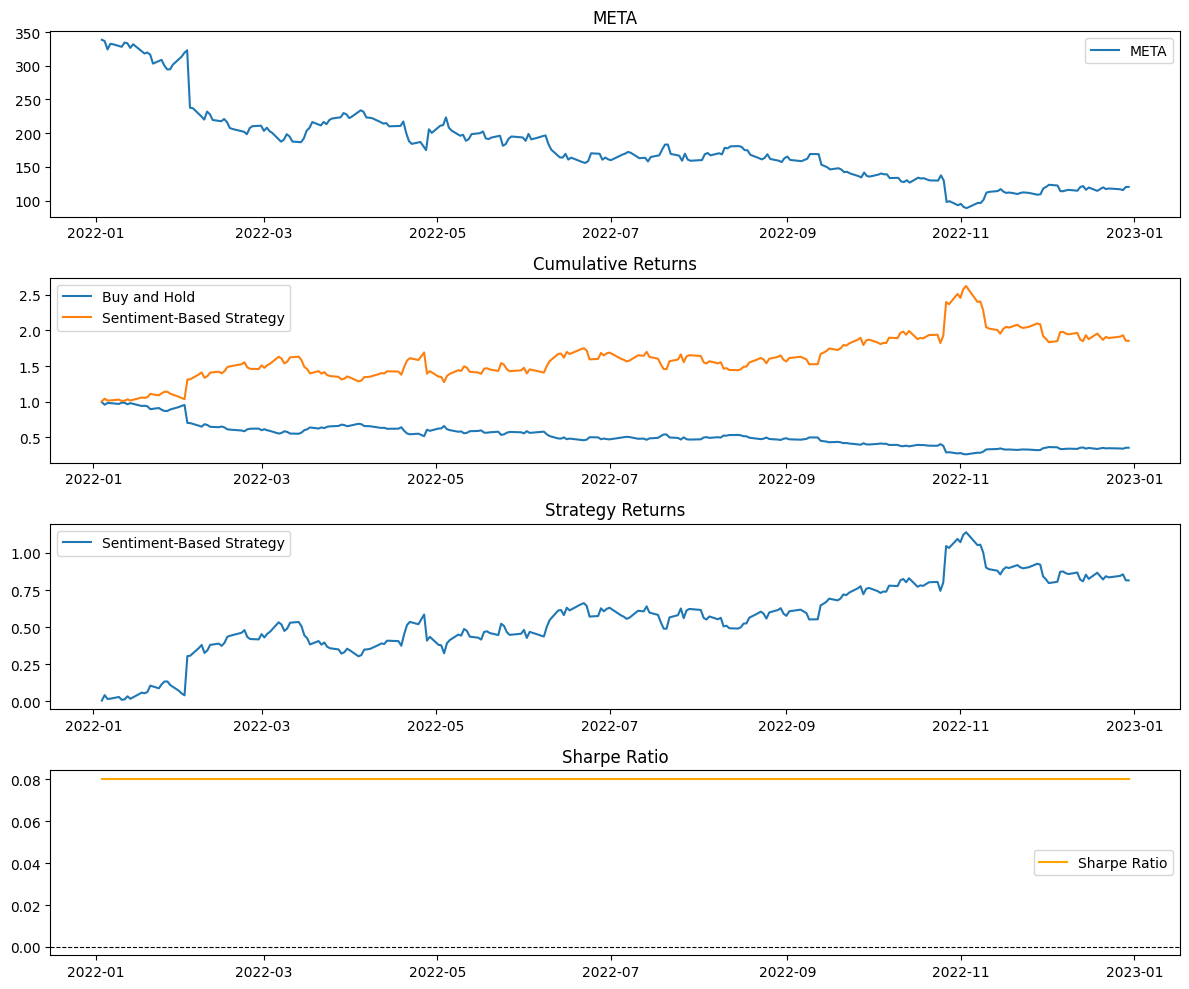

Sharpe Ratio: 0.0804


In [140]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

symbol = "META"
start_date = "2022-01-01"
end_date = "2023-01-01"

data = yf.download(symbol, start=start_date, end=end_date, interval="1d")

posts = pd.DataFrame(index=data.index)
posts['SentimentScore'] = 0
posts['Position'] = 0
posts['Position'][posts['SentimentScore'] > 0.6] = 1
posts['Position'][posts['SentimentScore'] <= 0.6] = -1

merged_data = pd.merge(data, posts, left_index=True, right_index=True, how='left')

merged_data['DailyReturns'] = merged_data['Close'].pct_change()
merged_data['StrategyReturns'] = merged_data['Position'] * merged_data['DailyReturns']
merged_data['CumulativeReturns'] = (1 + merged_data['DailyReturns']).cumprod()
merged_data['CumulativeStrategyReturns'] = (1 + merged_data['StrategyReturns']).cumprod()

average_strategy_return = merged_data['StrategyReturns'].mean()
std_dev_strategy_return = merged_data['StrategyReturns'].std()
sharpe_ratio = average_strategy_return / std_dev_strategy_return

plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(merged_data['Close'], label=f'{symbol}')
plt.title(f'{symbol}')
plt.legend()

# Plot Cumulative Returns
plt.subplot(4, 1, 2)
plt.plot(merged_data['CumulativeReturns'], label='Buy and Hold')
plt.plot(merged_data['CumulativeStrategyReturns'], label='Sentiment-Based Strategy')
plt.legend()
plt.title('Cumulative Returns')

plt.subplot(4, 1, 3)
plt.plot(merged_data['StrategyReturns'].cumsum(), label='Sentiment-Based Strategy')
plt.legend()
plt.title('Strategy Returns')

plt.subplot(4, 1, 4)
sharpe_ratio_series = pd.Series(index=merged_data.index, data=sharpe_ratio)
plt.plot(sharpe_ratio_series, label='Sharpe Ratio', color='orange')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.legend()
plt.title('Sharpe Ratio')

plt.tight_layout()
plt.show()

print(f'Sharpe Ratio: {sharpe_ratio:.4f}')
